In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import astropy.units as u

from toolkit import get_phoenix_model_spectrum, EchelleSpectrum

Load model spectra

In [2]:
T_spot = 3800
T_mean = 4750
spec_spot = get_phoenix_model_spectrum(T_spot, log_g=4.5)
spec_mean = get_phoenix_model_spectrum(T_mean, log_g=4.5)

Load ARCES spectrum

In [3]:
standard_path = ('/Users/bmmorris/data/Q3UW04/UT160706/'
                 'BD28_4211.0034.wfrmcpc.fits')
standard_spectrum = EchelleSpectrum.from_fits(standard_path)
target_path = glob('/Users/bmmorris/data/Q1UW09/UT170317/HD266611*wfrmcpc.fits')[0]
target_spectrum = EchelleSpectrum.from_fits(target_path)

def nearest_order(wavelength):
    return np.argmin([abs(spec.wavelength.mean() - wavelength).value
                      for spec in target_spectrum.spectrum_list])

nearest_order_7055 = nearest_order(7055*u.Angstrom)
nearest_order_8860 = nearest_order(8860*u.Angstrom)

only_orders = list(range(nearest_order_8860-1, nearest_order_7055+1))
target_spectrum.continuum_normalize(standard_spectrum,
                                    polynomial_order=10,
                                    only_orders=only_orders,
                                    plot_masking=False)

rv_shifts = u.Quantity([target_spectrum.rv_wavelength_shift(order)
                        for order in only_orders])
median_rv_shift = np.median(rv_shifts)

target_spectrum.offset_wavelength_solution(median_rv_shift)

In [4]:
target_order_1 = target_spectrum.get_order(nearest_order_7055)
target_order_2 = target_spectrum.get_order(nearest_order_8860)

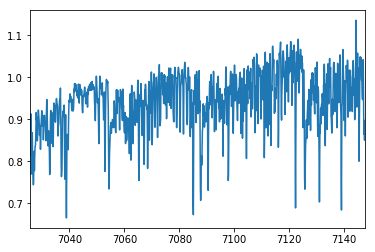

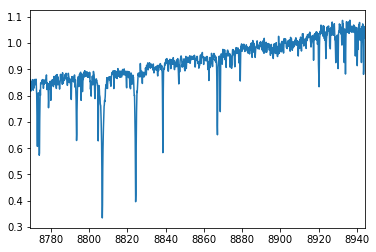

In [5]:
target_order_1.plot()
plt.figure()
target_order_2.plot()

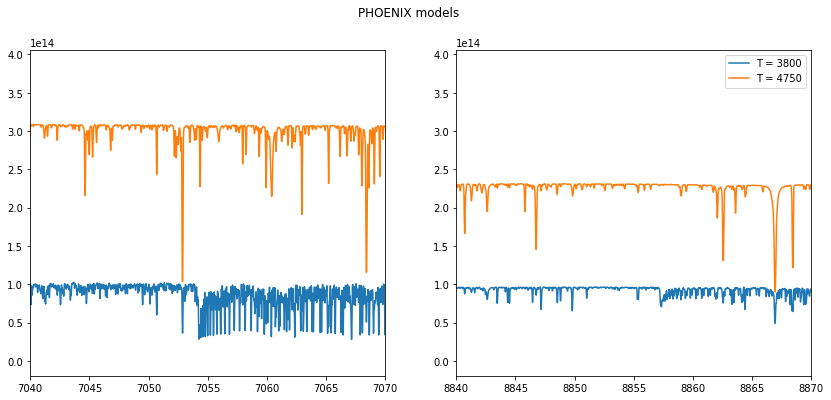

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(spec_spot.wavelength, spec_spot.flux, label='T = {0}'.format(T_spot))
ax[0].plot(spec_mean.wavelength, spec_mean.flux, label='T = {0}'.format(T_mean))
ax[0].set_xlim([7040, 7070])

ax[1].plot(spec_spot.wavelength, spec_spot.flux, label='T = {0}'.format(T_spot))
ax[1].plot(spec_mean.wavelength, spec_mean.flux, label='T = {0}'.format(T_mean))
ax[1].set_xlim([8840, 8870])
ax[1].legend()

fig.suptitle('PHOENIX models')

In [175]:
resolution_ratio

0.0764167992481899

In [184]:
from scipy.signal import gaussian, convolve

phoenix_resolution = np.median(spec_spot.wavelength.diff())
echelle_resolution = abs(np.median(target_order_1.wavelength.diff()))
resolution_ratio = 0.7 * (echelle_resolution/phoenix_resolution).value
smoothing_kernel = gaussian(int(10*resolution_ratio), resolution_ratio)

In [185]:
from toolkit.spectra import Spectrum1D
from scipy.signal import gaussian

def convolve_spectrum(spectrum, resolution_ratio):
    smoothing_kernel = gaussian(int(10*resolution_ratio), resolution_ratio)
    convolved_flux = convolve(spectrum.flux, smoothing_kernel, mode='same')
    convolved_spectrum = Spectrum1D.from_array(spectrum.wavelength, 
                                               convolved_flux/np.median(convolved_flux))
    return convolved_spectrum

def broaden(flux, resolution_ratio):
    smoothing_kernel = gaussian(int(10*resolution_ratio), resolution_ratio)
    convolved_flux = convolve(flux, smoothing_kernel, mode='same')
    return convolved_flux/np.max(convolved_flux)

In [186]:
spec_mean_conv = convolve_spectrum(spec_mean, resolution_ratio)
spec_spot_conv = convolve_spectrum(spec_spot, resolution_ratio)

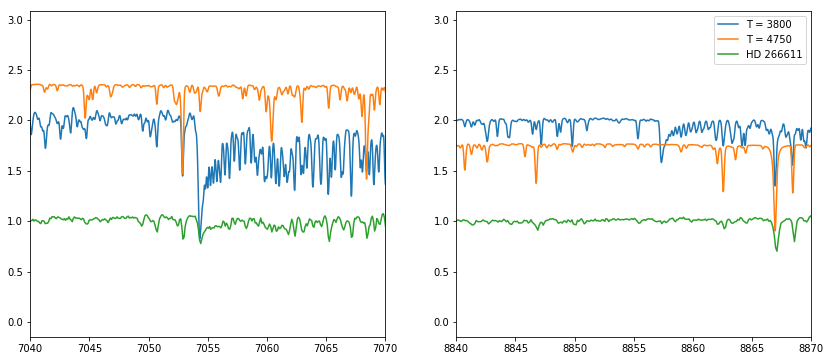

In [187]:
# plt.plot(spec_mean.wavelength, 
#          convolve(spec_mean.flux, smoothing_kernel, mode='same'))

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(spec_spot_conv.wavelength, spec_spot_conv.flux, 
           label='T = {0}'.format(T_spot))
ax[0].plot(spec_mean_conv.wavelength, spec_mean_conv.flux, 
           label='T = {0}'.format(T_mean))
ax[0].plot(target_order_1.masked_wavelength, 
           target_order_1.masked_flux/target_order_1.masked_flux.mean(), 
           label=target_spectrum.name)
ax[0].set_xlim([7040, 7070])

ax[1].plot(spec_spot_conv.wavelength, spec_spot_conv.flux, 
           label='T = {0}'.format(T_spot))
ax[1].plot(spec_mean_conv.wavelength, spec_mean_conv.flux, 
           label='T = {0}'.format(T_mean))
ax[1].plot(target_order_2.masked_wavelength, 
           target_order_2.masked_flux/target_order_2.masked_flux.mean(), 
           label=target_spectrum.name)
ax[1].set_xlim([8840, 8870])
ax[1].legend()


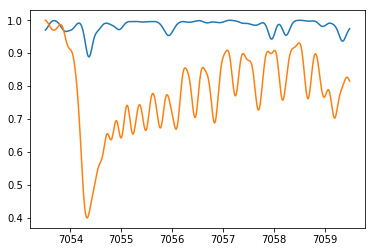

In [306]:
from toolkit import slice_spectrum

#lam1, lam2 = 7040*u.Angstrom, 7070*u.Angstrom
lam1, lam2 = 7053.5*u.Angstrom, 7059.5*u.Angstrom
spec_mean_slice = slice_spectrum(spec_mean_conv, lam1, lam2, norm=True)
spec_spot_slice = slice_spectrum(spec_spot_conv, lam1, lam2, norm=True)
target_masked = Spectrum1D.from_array(target_order_1.masked_wavelength,
                                      target_order_1.masked_flux)
target_slice = slice_spectrum(target_masked, lam1, lam2, norm=True)

plt.plot(spec_mean_slice.wavelength, spec_mean_slice.flux)
plt.plot(spec_spot_slice.wavelength, spec_spot_slice.flux)
#plt.plot(target_slice.wavelength, target_slice.flux)

In [307]:
from scipy.optimize import fmin_l_bfgs_b

interp_mean = np.interp(target_slice.wavelength, 
                        spec_mean_slice.wavelength, spec_mean_slice.flux)

interp_spot = np.interp(target_slice.wavelength, 
                        spec_spot_slice.wavelength, spec_spot_slice.flux)

def model(p, f0, f1):
    p0, p1 = np.exp(p)
    return p0 * f0 + p1 * f1

def minimize(p, s, f0, f1):
    return np.sum((model(p, f0, f1) - s)**2)


initp = [-0.69, -0.69]
args = (target_slice.flux, interp_mean, interp_spot)
bounds = [[-100, 10], [-100, 10]]

result = fmin_l_bfgs_b(minimize, initp, approx_grad=True, bounds=bounds, 
                       args=args)
best_model = model(result[0], *args[1:])

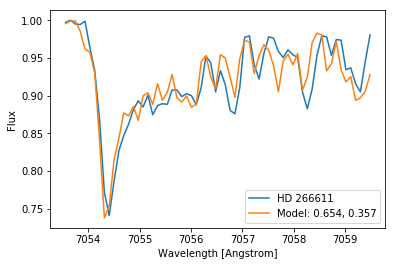

In [308]:
plt.plot(target_slice.wavelength, target_slice.flux, label='HD 266611')
plt.plot(target_slice.wavelength, best_model, 
         label="Model: " + ', '.join(map("{0:.3f}".format, np.exp(result[0]))))
plt.xlabel('Wavelength [Angstrom]')
plt.ylabel('Flux')
plt.legend()

CaOH 6345-6354 A
bluer bands of TiO see PMSU papers: [Reid 1995 table 2](http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1995AJ....110.1838R&amp;data_type=PDF_HIGH&amp;whole_paper=YES&amp;type=PRINTER&amp;filetype=.pdf)

go to the phoenix model line lists

MK mwo spectra only had blue: what were their TiO bands?



In [326]:
from toolkit import phoenix_model_temps

test_temps = np.sort(phoenix_model_temps[(phoenix_model_temps < 6000) & 
                                         (phoenix_model_temps > 3000)])
all_models = np.zeros((each_model.flux.shape[0], len(test_temps)))
wavelengths = np.zeros(each_model.flux.shape[0])

for i, test_temp in enumerate(test_temps):
    if i == 0:
        wavelengths_order = np.argsort(each_model.wavelength)
        wavelengths = each_model.wavelength[wavelengths_order]
    
    each_model = get_phoenix_model_spectrum(test_temp, log_g=4.5, cache=True)
    all_models[:, i] = each_model.flux[wavelengths_order]

In [327]:
from scipy.interpolate import interp2d, RectBivariateSpline

interp_models = RectBivariateSpline(wavelengths.value, test_temps, all_models,
                                    kx=3, ky=3)

def interp_models_reshape(lam, temp):
    return interp_models(lam, temp)[:, 0]

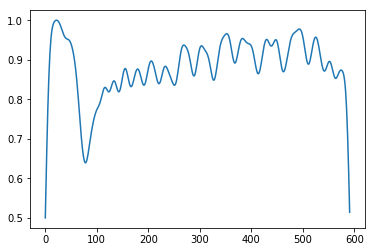

In [328]:
#lam_sort = np.sort(target_slice.wavelength)
lmin, lmax = target_slice.wavelength.min(), target_slice.wavelength.max()
lams = wavelengths[(wavelengths > lmin) & (wavelengths < lmax)]

model_spectrum_1 = interp_models_reshape(lams, 3800)
model_spectrum_2 = interp_models_reshape(lams, 4500)

model_spectrum_1 /= model_spectrum_1.max()
model_spectrum_2 /= model_spectrum_2.max()

plt.plot(broaden(0.5 * model_spectrum_1 + 0.5 * model_spectrum_2, resolution_ratio))

In [329]:
# # Plot grid of all spectra
# ax = plt.gca()
# ax.imshow(np.log(all_models), 
#           vmin=np.log(all_models).mean(), 
#           vmax=np.log(all_models).mean()+1)
# ax.set_aspect(1e-5)

In [330]:
bounds

[[-100, 10],
 [-100, 10],
 [1.4843740240456342, 2.12968334402249],
 [8.039157390473237, 8.366370301681654],
 [8.366370301681654, 8.630521876723241]]

In [331]:
from scipy.interpolate import interp1d

def model(p, s):
#     p0, p1, b = np.exp(p[:3])
#     t1, t2 = p[3:]

    p0, p1, b, t1, t2 = np.exp(p)
        
    lmin, lmax = s.wavelength.min(), s.wavelength.max()
    lams = wavelengths[(wavelengths >= lmin) & (wavelengths <= lmax)]
    
    model_spectrum_1 = interp_models_reshape(lams, t1)
    model_spectrum_2 = interp_models_reshape(lams, t2)

    model_spectrum_1 /= model_spectrum_1.max()
    model_spectrum_2 /= model_spectrum_2.max()
    
    broadened_spectrum = broaden(p0 * model_spectrum_1 + p1 * model_spectrum_2, b)
    
    #broad_interp = np.interp(s.wavelength, lams, broadened_spectrum)
    broad_interp = interp1d(lams, broadened_spectrum, bounds_error=False,
                            assume_sorted=True, fill_value=1)
    return broad_interp(s.wavelength)

def minimize(p, s):
    return np.sum((model(p, s) - s.flux)**2)

# initp = [-0.69, -0.69, np.log(resolution_ratio), 
#          np.log(3800), np.log(4700)]
# cuttof_temp = 4200

cutoff_temp = 4300
initp = [-0.69, -0.69, np.log(resolution_ratio), 
         np.log(3900), np.log(4400)]
         
args = (target_slice, )# , interp_mean, interp_spot)
temp_bounds = np.log([test_temps.min(), test_temps.max()]).tolist()
#bounds = [[-100, 10], [-100, 10], [-10, 10], temp_bounds, temp_bounds]

bounds = [[-100, 10], [-100, 10], 
          [np.log(resolution_ratio - 2), np.log(resolution_ratio + 2)], #[-10, 10], 
          np.log([test_temps.min(), cutoff_temp]).tolist(), 
          np.log([cutoff_temp, test_temps.max()]).tolist()]

result = fmin_l_bfgs_b(minimize, initp, approx_grad=True, 
                       bounds=bounds, args=args)
best_model = model(result[0], *args)
print(bounds)
print(result[0])

[[-100, 10], [-100, 10], [1.4843740240456342, 2.12968334402249], [8.039157390473237, 8.366370301681654], [8.366370301681654, 8.68270762989381]]
[-0.76420924 -0.6157908   1.79175951  8.27049621  8.64574209]


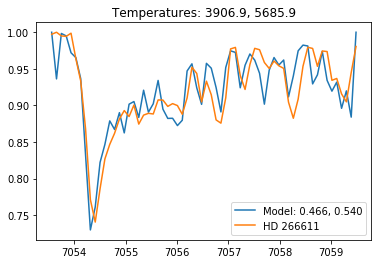

In [332]:
plt.plot(target_slice.wavelength, best_model, 
         label="Model: " + ', '.join(map("{0:.3f}".format, np.exp(result[0][:2]))))
plt.plot(target_slice.wavelength, target_slice.flux, label='HD 266611')
plt.title("Temperatures: {0:.1f}, {1:.1f}".format(*np.exp(result[0][-2:])))
plt.legend()